In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill as pickle

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)
from cities.utils.cleaning_utils import check_if_tensed 
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference, train_interactions_model)


ImportError: cannot import name 'plot_predictive' from 'cities.modeling.modeling_utils' (/home/rafal/s78projects/cities/cities/modeling/modeling_utils.py)

In [ ]:
data = prep_data_for_interaction_inference(outcome_dataset='unemployment_rate',
intervention_dataset='spending_commerce',intervention_variable='total_obligated_amount',
forward_shift = 2)

for key, value in data.items():
    globals()[key] = value


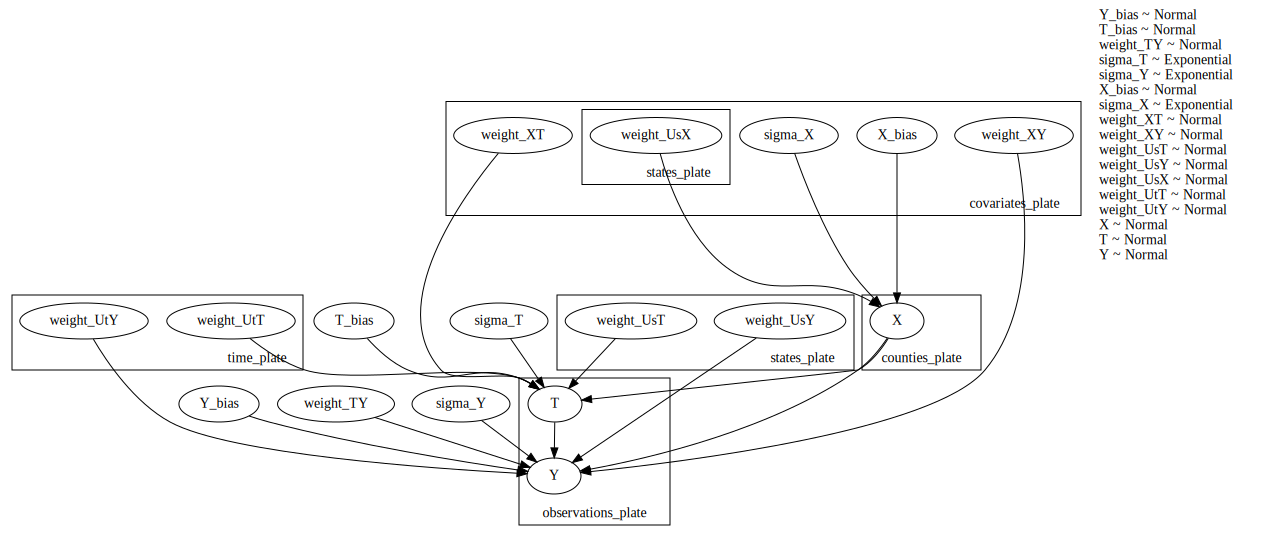

In [ ]:
model_args = model_args=(N_t, N_cov, N_s, N_u, N_obs, state_index_sparse, state_index, time_index, unit_index)

pyro.render_model(model, 
                  model_args=model_args, render_distributions=True)

[iteration 0001] loss: 102704.8042


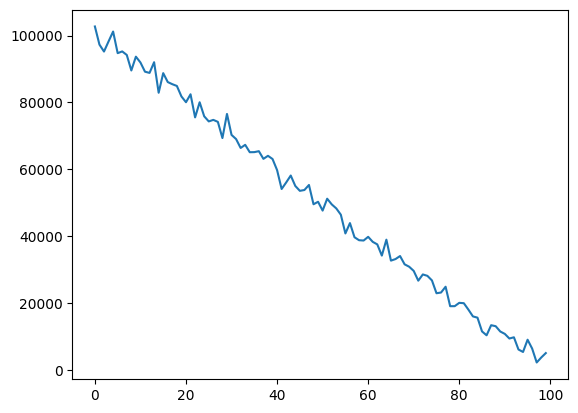

In [ ]:
# low num_iterations as this is a smoke test

model_conditioned = pyro.condition(model, data = {"T": intervention, "Y": y, "X": covariates_sparse})

guide = train_interactions_model(model_conditioned, model_args = model_args, num_iterations= 1000)

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=500, parallel=False)
samples = predictive(*model_args)

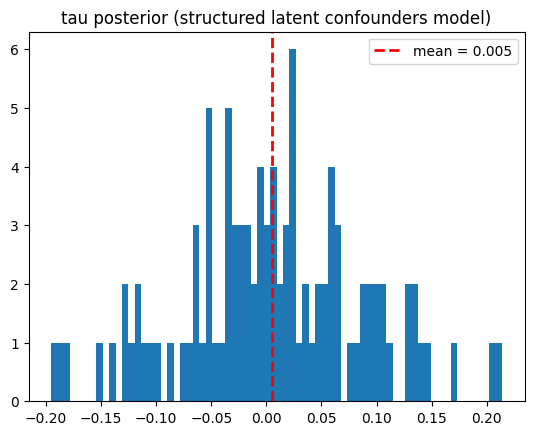

In [ ]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (structured latent confounders model)")
plt.legend()
plt.show()

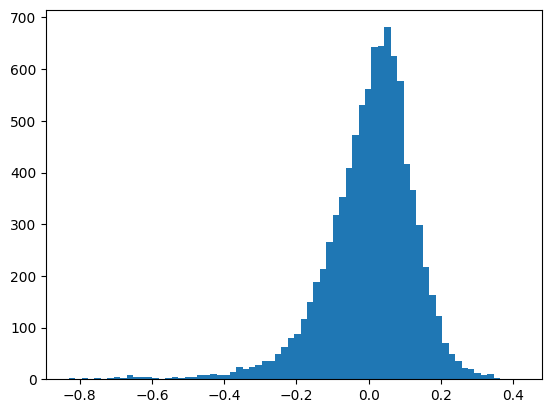

In [ ]:
# plot residuals

predictions = samples['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)

plt.hist(mean_predictions - y, bins=70)
plt.show()

In [11]:
observed_mean = torch.mean(y)
tss = torch.sum((y - observed_mean) ** 2)
print("tss", tss)
rss = torch.sum((y - mean_predictions) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

tss tensor(206.3684)
rss tensor(144.7742)
r_squared tensor(0.2985)


In [12]:
# testing if sampling in multiple counterfactual worlds works

with MultiWorldCounterfactual() as mwc_D:
    with do(actions=dict(intervention=(-0.9, .9))):
        samples = predictive(*model_args)
        